<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Convection-linéaire" data-toc-modified-id="Convection-linéaire-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Convection linéaire</a></span></li><li><span><a href="#Convection-non-linéaire" data-toc-modified-id="Convection-non-linéaire-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Convection non-linéaire</a></span></li><li><span><a href="#Convergence-et-condition-CFL" data-toc-modified-id="Convergence-et-condition-CFL-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Convergence et condition CFL</a></span></li><li><span><a href="#Diffusion-1D" data-toc-modified-id="Diffusion-1D-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Diffusion 1D</a></span></li><li><span><a href="#Equation-de-Burger" data-toc-modified-id="Equation-de-Burger-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Equation de Burger</a></span><ul class="toc-item"><li><span><a href="#Condition-initiale-et-conditions-aux-limites" data-toc-modified-id="Condition-initiale-et-conditions-aux-limites-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Condition initiale et conditions aux limites</a></span></li></ul></li><li><span><a href="#Convection-en-dimension-2" data-toc-modified-id="Convection-en-dimension-2-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Convection en dimension 2</a></span></li></ul></div>

**Convection linéaire**


L'équation de convection linéaire 1-D est le modèle le plus simple permettant d'illustrer les enjeux numériques de la résolution numérique des équations de Navier-Stokes

$$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0$$

Avec des conditions initiales données (comprises comme une *onde*), l'équation représente la propagation de cette *onde* initiale avec la vitesse $c$, sans changement de forme. Soit la condition initiale $u(x,0)=u_0(x)$. Alors la solution exacte de l'équation est $u(x,t)=u_0(x-ct)$.

Nous discrétisons cette équation à la fois dans l'espace et dans le temps, en utilisant le schéma de différence avant pour la dérivée temporelle et le schéma de différence arrière pour la dérivée spatiale. Envisagez de discrétiser la coordonnée spatiale $x$ en points que nous indexons de $i=0$ à $N$, et de progresser par intervalles de temps discrets de taille $\Delta t$.

De la définition d'une dérivée (et en supprimant simplement la limite), nous savons que :

$$\frac{\partial u}{\partial x}\approx \frac{u(x+\Delta x)-u(x)}{\Delta x}$$

Notre équation discrète est donc :

$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + c \frac{u_i^n - u_{i-1}^n}{\Delta x} = 0 $$

Où $n$ et $n+1$ sont deux étapes consécutives dans le temps, tandis que $i-1$ et $i$ sont deux points voisins de la coordonnée $x$ discrétisée. Si on donne des conditions initiales, alors la seule inconnue dans cette discrétisation est $u_i^{n+1}$. Nous pouvons résoudre notre inconnue pour obtenir une équation qui nous permet d'avancer dans le temps, comme suit :

$$u_i^{n+1} = u_i^n - c \frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)$$

Essayons maintenant de l'implémenter en Python.

Nous allons commencer par importer quelques bibliothèques pour nous aider.

*`numpy` est une bibliothèque qui fournit un tas d'opérations matricielles utiles similaires à MATLAB* `matplotlib` est une bibliothèque de traçage 2D que nous utiliserons pour tracer nos résultats
* `time` et `sys` fournissent des fonctions de synchronisation de base que nous utiliserons pour ralentir les animations pour la visualisation

In [2]:
import numpy as np                     #chargement de numpy (calcul)
from matplotlib import pyplot          #chargement de matplotlib (graphiques)
import time, sys                       #chargement des utilitaires
import matplotlib.pyplot as plt
%matplotlib inline

Nous avons besoin de définir quelques variables nécessaires à la résolution numérique de l'équation

In [3]:
nx = 50         # discrétisation : nombre de point pour décrire le domaine
dx = 2 / (nx-1)  # distance entre 2 points
nt = 25          # nombre de pas de temps à réaliser
dt = .025        # pas de temps
c = 1.1            # vitesse de propagation de l'onde

Pour résoudre l'quation, il est nécessaire de déinir les coniditons initiales. La vitesse initiale $u_0$ est donnée par $u = 2$ dans l'intervalle $0.5 \leq x \leq 1$ et $u = 1$ partout ailleurs dans $(0,2)$ (c'est-à-dire une fonction chapeau).

In [4]:
u = np.ones(nx)
u[int(.5 / dx):int(1 / dx + 1)] = 2
print(u)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


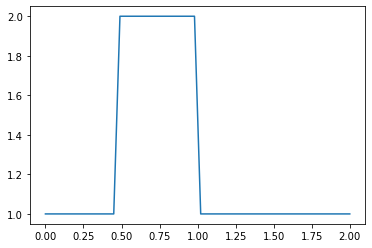

In [5]:
pyplot.plot(np.linspace(0, 2, nx), u);

Il est maintenant temps d'implémenter la discrétisation de l'équation de convection en utilisant un schéma aux différences finies.

Pour chaque élément de notre tableau `u`, nous devons effectuer l'opération $u_i^{n+1} = u_i^n - c \frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)$

Nous stockerons le résultat dans un nouveau tableau (temporaire) `un`, qui sera la solution $u$ pour le prochain pas de temps. Nous répéterons cette opération pour autant de pas de temps que nous spécifierons et nous pourrons alors voir jusqu'où l'onde a convecté.

Nous initialisons d'abord notre tableau d'espace réservé `un` pour contenir les valeurs que nous calculons pour le pas de temps $n+1$, en utilisant à nouveau la fonction NumPy `ones()`.

Ensuite, nous pouvons penser que nous avons deux opérations itératives : une dans l'espace et une dans le temps (nous apprendrons différemment plus tard), alors nous commencerons par imbriquer une boucle dans l'autre. Notez l'utilisation de la fonction astucieuse `range()`. Lorsque nous écrivons : `for i in range(1,nx)` nous parcourrons le tableau `u`, mais nous sauterons le premier élément (le zéro-ième élément).

In [7]:
nt = 5 #Changer le nombre d'itérations en temps pour choisir le moment où l'onde est visualisée. 

In [6]:
un = np.ones(nx)                # initialisation du champ de l'itération n

for n in range(nt):                # itération en temps
    un = u.copy()                  # copie de l'itération précédente dans la valeur courante
    for i in range(nx):
        u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])

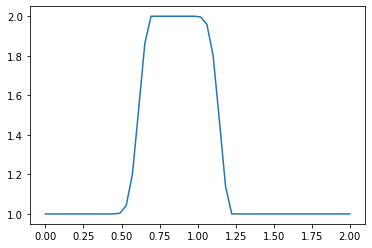

In [9]:
pyplot.plot(np.linspace(0, 2, nx), u);

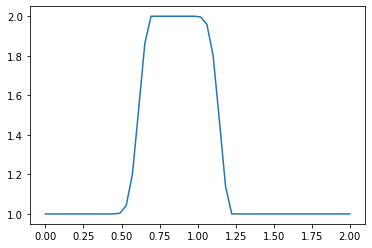

In [10]:
pyplot.plot(np.linspace(0, 2, nx), u);

**Convection non-linéaire**

Nous allons maintenant implémenter la convection non linéaire en utilisant les mêmes méthodes qu'à l'étape 1. L'équation de convection 1D est :

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0$$

Au lieu d'un facteur constant $c$ multipliant le deuxième terme, nous avons maintenant la solution $u$ le multipliant. Ainsi, le deuxième terme de l'équation est maintenant *non linéaire*. Nous allons utiliser la même discrétisation qu'à l'étape 1 - différence avant dans le temps et différence arrière dans l'espace. Voici l'équation discrétisée.

$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + u_i^n \frac{u_i^n-u_{i-1}^n}{\Delta x} = 0$$

La résolution du seul terme inconnu, $u_i^{n+1}$, donne :

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n)$$

Comme précédemment, le code Python commence par charger les bibliothèques nécessaires. Ensuite, nous déclarons quelques variables qui déterminent la discrétisation dans l'espace et dans le temps (vous devriez expérimenter en modifiant ces paramètres pour voir ce qui se passe). Ensuite, nous créons la condition initiale $u_0$ en initialisant le tableau pour la solution en utilisant $u = 2\ @\ 0.5 \leq x \leq 1$ et $u = 1$ partout ailleurs dans $(0,2)$ (c'est-à-dire une fonction chapeau).

**Question** Ecrire la résolution de l'équation de convection non linéaire.

Nous avons implémenté les mêmes résolutions en modifiant l'un des termes. Nous constatons que certaines limitations apparaissent en affichant des résultats. Nous avons pris un jeu de paramètres aux valeurs plus petites pour cette raison.

In [11]:
nx = 25   #Échantillonnage 
nt = 14   #Nombre de pas de temps (itérations)
dx = 2 / (nx - 1)
dt = 0.025 #Pas de temps

In [13]:
u = np.ones(nx)                 # initialisation du vecteur solution de l'équation
u[10:20] = 2                     # définition de la condition initiale
un = np.ones(nx)                # initialisation du champ de l'itération n

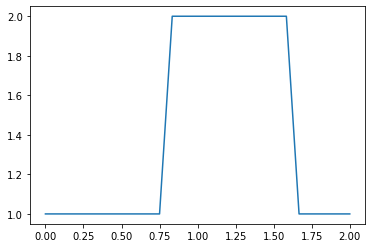

In [14]:
plt.plot(np.linspace(0,2,nx), u)

In [15]:
for n in range(nt):                # itération en temps
    un = u.copy()                  # copie de l'itération précédente dans la valeur courante
    for i in range(nx):
        u[i] = un[i] - un[i] * dt / dx * (un[i] - un[i-1])

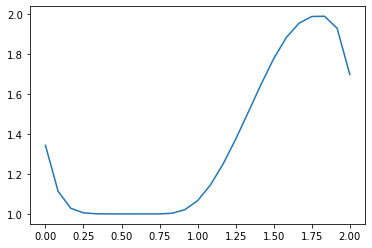

In [16]:
plt.plot(np.linspace(0,2,nx), un)

# Convergence et condition CFL


Pour les premières étapes, nous avons utilisé les mêmes conditions générales initiales et aux limites. Avec les paramètres que nous avons initialement proposés, la grille comporte 41 points et le pas de temps est de 0,25 seconde. Maintenant, nous allons expérimenter l'augmentation de la taille de notre grille. Le code ci-dessous est identique au code que nous avons utilisé dans [Step 1](./01_Step_1.ipynb), mais ici, il a été regroupé dans une fonction afin que nous puissions facilement examiner ce qui se passe comme nous ajustons une seule variable : **la taille de la grille**.

In [7]:
def convection(nx):
    dx = 2 / (nx-1)  # distance entre 2 points
    nt = 25          # nombre de pas de temps à réaliser
    dt = .025        # pas de temps
    c = 1            # vitesse de propagation de l'onde

    u = np.ones(nx)                 # initialisation du vecteur solution de l'équation
    u[int(.5/dx):int(1 / dx + 1)] = 2  # définition de la condtion initiale

    un = np.ones(nx)                # initialisation du champ de l'itération n
    for n in range(nt):                # iteration en temps
        un = u.copy()                  # copie de l'itération précédente
        for i in range(1, nx):
            u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])
        
    pyplot.plot(np.linspace(0, 2, nx), u);
    #plt.legend(nx)

**Question** 
Executer la fonction en faisant varier le nombre de point de discrétisation entre $40$ et $90$.

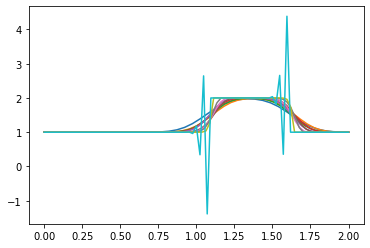

In [8]:
for nx in range(40,90,5):
    convection(nx)
    

**Question**
Qu'observez vous?

-- Nous observons que le signal u oscille fortement autour des positions t = 1.00 et t = 1.6 lorsque nx augmente.

Afin d'expliquer ce que l'on observe, il faut analyser la manière dont les itérations se déroulent.

Lors d'une itération en temps, nous utilisons les informations transportées par l'équation, ce qui permet d'évaluer le champs de vitesse au pas de temps suivant.

La diminution du pas d'espace, c'est à dire l'augmentation du nombre de point de discrétisation permet d'améliorer la qualité de la solution. La forme initiale de l'onde de vitese est conservée.

A chaque itération, l'onde de vitesse parcourt une distance égale à $c*\Delta t$. Si cette distance est supèrieur à $dx$, l'information de l'onde n'est pas suffisament précise aux points de discrétisations. Il faut donc dériver une condition de stabilité de l'équation.

$$\sigma = \frac{u \Delta t}{\Delta x} \leq \sigma_{\max}$$

où $u$ est la vitesse de l'onde ; $\sigma$ est appelé le **nombre de Courant** et la valeur de $\sigma_{\max}$ qui assurera la stabilité dépend de la discrétisation utilisée.

Dans ce qui suit, nous utiliserons le nombre CFL pour calculer un pas de temps approprié `dt` en fonction de la taille de `dx`.

**Diffusion 1D**


L'équation de diffusion unidimensionnelle est :

$$\frac{\partial u}{\partial t}= \nu \frac{\partial^2 u}{\partial x^2}$$

La dérivée du second ordre peut être représentée géométriquement comme la ligne tangente à la courbe donnée par la dérivée première. Nous allons discrétiser la dérivée du second ordre avec un schéma de différence centrale : une combinaison de différence avant et de différence arrière de la dérivée première. Considérez le développement de Taylor de $u_{i+1}$ et $u_{i-1}$ autour de $u_i$ :

$u_{i+1} = u_i + \Delta x \frac{\partial u}{\partial x}\bigg|_i + \frac{\Delta x^2}{2} \frac{\partial ^2 u}{\partial x^2}\bigg|_i + \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\bigg|_i + O(\Delta x^4)$

$u_{i-1} = u_i - \Delta x \frac{\partial u}{\partial x}\bigg|_i + \frac{\Delta x^2}{2} \frac{\partial ^2 u}{\partial x^2}\bigg|_i - \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\bigg|_i + O(\Delta x^4)$

Si nous additionnons ces deux développements, vous pouvez voir que les termes dérivés impairs s'annuleront. Si nous négligeons tous les termes de $O(\Delta x^4)$ ou plus (et vraiment, ceux-ci sont très petits), alors nous pouvons réorganiser la somme de ces deux expansions pour résoudre notre dérivée seconde.

$u_{i+1} + u_{i-1} = 2u_i+\Delta x^2 \frac{\partial ^2 u}{\partial x^2}\bigg|_i + O(\Delta x^4)$

Ensuite, réorganisez pour résoudre pour $\frac{\partial ^2 u}{\partial x^2}\bigg|_i$ et le résultat est :

$$\frac{\partial ^2 u}{\partial x^2}=\frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^2} + O(\Delta x^2)$$.

On peut maintenant écrire la version discrétisée de l'équation de diffusion en 1D :

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^2}$$

Comme précédemment, nous remarquons qu'une fois que nous avons une condition initiale, la seule inconnue est $u_{i}^{n+1}$, nous réorganisons donc l'équation en résolvant notre inconnue :

$$u_{i}^{n+1}=u_{i}^{n}+\frac{\nu\Delta t}{\Delta x^2}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})$$

L'équation discrète ci-dessus nous permet d'écrire un programme pour avancer une solution dans le temps. Mais nous avons besoin d'une condition initiale. Nous utiliserons dans un premier temps la fonction chapeau. 

Donc, à $t=0$, $u=2$ dans l'intervalle $0.5\le x\le 1$ et $u=1$ partout ailleurs.

**Question** Ecrire une fonction qui permet de résoudre l'équation de diffusion.

In [37]:
def diffusion(nx):
    dx = 2 / (nx-1)  # distance entre 2 points
    nt = 1000          # nombre de pas de temps à réaliser
    dt = .5        # pas de temps
    nu = 1e-5            # vitesse de propagation de l'onde

    u = np.ones(nx)                 # initialisation du vecteur solution de l'équation
    u[int(.5/dx):int(1 / dx + 1)] = 2  # définition de la condtion initiale
    
    un = np.ones(nx)                # initialisation du champ de l'itération n
    for n in range(nt):                # iteration en temps
        un = u.copy()                  # copie de l'itération précédente
        for i in range(1, nx-1):
            u[i] = un[i] +  nu * (dt / (dx**2)) * (un[i+1] - 2*un[i] + un[i-1])
        
    pyplot.plot(np.linspace(0, 2, nx), u);
    
    return u 

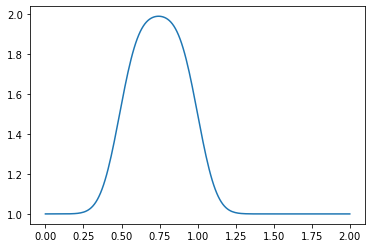

In [38]:
#for nx in range(20, 1000, 10):
nx = 200
u = diffusion(nx)
#pyplot.plot(u);

**Equation de Burger**

L'équation de Burgers, une simplification des équations de Navier-Stokes, dans une dimension spatiale s'écrit  :

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial ^2u}{\partial x^2}$$

C'est une combinaison de convection non linéaire et de diffusion.

Nous pouvons le discrétiser en utilisant les méthodes que nous avons déjà détaillées dans les étapes précédents. En utilisant la différence avant pour le temps, la différence arrière pour l'espace et notre méthode du 2e ordre pour les dérivées secondes, on obtient :

$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + u_i^n \frac{u_i^n - u_{i-1}^n}{\Delta x} = \nu \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}$$

Comme précédemment, une fois que nous avons une condition initiale, la seule inconnue est $u_i^{n+1}$. Nous avancerons dans le temps comme suit :

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

**Condition initiale et conditions aux limites**

Pour examiner certaines propriétés intéressantes de l'équation de Burgers, il est utile d'utiliser des conditions initiales et aux limites différentes de celles que nous avons utilisées pour les étapes précédentes.

La condition initiale pour ce problème va être :

\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-x^2}{4 \nu} \bigg) + \exp \bigg(\frac{-(x-2 \pi)^2}{4 \nu} \bigg)
\end{eqnarray}

Celle-ci admet une solution analytique, donnée par :

\begin{eqnarray}
u &=& -\frac{2 \nu}{\phi} \frac{\partial \phi}{\partial x} + 4 \\\
\phi &=& \exp \bigg(\frac{-(x-4t)^2}{4 \nu (t+1)} \bigg) + \exp \bigg(\frac{-(x-4t -2 \pi)^2}{4 \nu(t+1)} \bigg)
\end{eqnarray}

La condition aux limites sera :

$$u(0) = u(2\pi)$$

C'est ce qu'on appelle une condition aux limites *périodique*.

**Question** Tracer la condition initiale du problème.

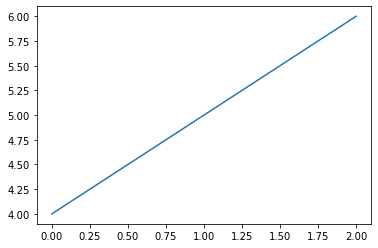

In [57]:
#Programme pour afficher la condition Burger initiale
import math

#pi = 3.14
nu = 1e-2

phi = lambda x, nu : np.exp(-(x**2)/(4*nu)) + np.exp(-(x - (2*pi))**2 / (4*nu))

dxphi = lambda x, nu : (-1 / (2*nu))*x*np.exp( (-x**2) / (4*nu) ) - (1 / (4*nu))*(2*x + 2*pi)*np.exp( -((x - 2*pi)**2) / (4*nu))
    
u = lambda x, nu : ((-2*nu)/phi(x,nu))*(dxphi(x,nu)) + 4


X = np.linspace(0, 2, 1000)
V = u(X,nu)

#print(V)

plt.plot(X, V)

**Question** Ecrire une fonction de résolution de l'équation de Burgers

\section{Convection en dimension 2}

Nous allons maintenant étendre les formules aux différences finies 1D aux dérivées partielles en 2D ou 3D, il suffit d'appliquer la définition : une dérivée partielle par rapport à $x$ est la variation dans la direction $x$ *à constante* $y$.

Dans l'espace 2D, une grille rectangulaire (uniforme) est définie par les points de coordonnées :

$$x_i = x_0 +i \Delta x$$

$$y_i = y_0 +i \Delta y$$

Maintenant, définissez $u_{i,j} = u(x_i,y_j)$ et appliquez les formules aux différences finies sur l'une ou l'autre des variables $x,y$ *agissant séparément* sur les indices $i$ et $j$. Toutes les dérivées sont basées sur le développement de Taylor 2D d'une valeur de point de maillage autour de $u_{i,j}$.

Par conséquent, pour une dérivée partielle du premier ordre dans la direction $x$, une formule aux différences finies est :

$$ \frac{\partial u}{\partial x}\biggr\rvert_{i,j} = \frac{u_{i+1,j}-u_{i,j}}{\Delta x}+\mathcal{O}(\Delta x)$$

et de même dans la direction $y$. Ainsi, nous pouvons écrire des formules de différence arrière, de différence avant ou de différence centrale. 

La discrétisation de l'EDP devient 

$$\frac{u_{i,j}^{n+1}-u_{i,j}^n}{\Delta t} + c\frac{u_{i, j}^n-u_{i-1,j}^n}{\Delta x} + c\frac{u_{i,j}^n-u_{i,j-1}^n}{\Delta y}=0$$

Comme précédemment, on résout pour une seule inconnue :

$$u_{i,j}^{n+1} = u_{i,j}^n-c \frac{\Delta t}{\Delta x}(u_{i,j}^n-u_{i-1,j}^n)-c \frac{\Delta t}{\Delta y}(u_{i,j}^n-u_{i,j-1}^n)$$

Nous allons résoudre cette équation avec les conditions initiales suivantes :

$$u(x,y) = \begin{cases}
\begin{matrix}
2\ \text{for} & 0.5 \leq x, y \leq 1 \cr
1\ \text{for} & \text{everywhere else}\end{matrix}\end{cases}$$

et les conditions aux limites :

$$u = 1\ \text{for } \begin{cases}
\begin{matrix}
x =  0,\ 2 \cr
y =  0,\ 2 \end{matrix}\end{cases}$$

Passons à la résolution de l'équation

/var/folders/yj/0_wsrptd5t965kc7bdhqpklw0000gn/T/ipykernel_77092/1809440206.py:30: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


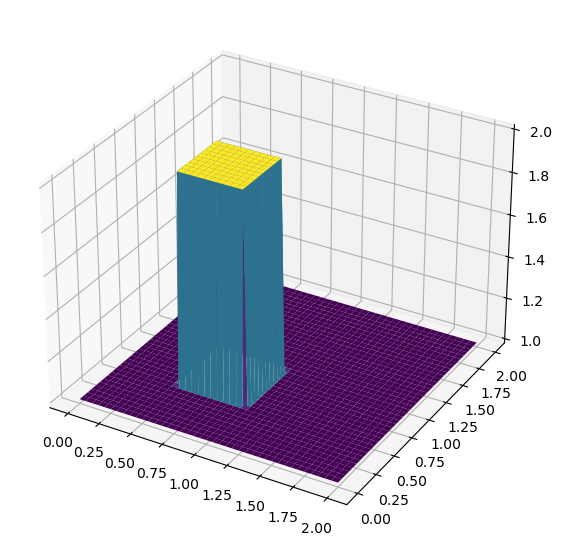

In [10]:
from mpl_toolkits.mplot3d import Axes3D    ## Permet de faire des représentations 3d

import numpy
from matplotlib import pyplot, cm
%matplotlib inline

### Declarations des variables
nx = 81
ny = 81
nt = 100
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)

u = numpy.ones((ny, nx))  ## 
un = numpy.ones((ny, nx)) ##

### Assigner les conditions aux limites

## Définir la fonction chapeau pour les conditions initiales   : u(.5<=x<=1 && .5<=y<=1 ) =2
u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 

### Affichage de la condition initiale
fig = pyplot.figure(figsize=(11, 7), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = numpy.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)


**Question** Ecrire une fonction de résolution de l'équation de convection en dimension 2.